In [35]:
#### We will be using machine learning techniques for image similarity initially to get a benchmark solution before applying deep leaarning technique

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from imutils import paths
import numpy as np
import argparse
import imutils
import os

In [2]:
def image_to_feature_vector(image, size=(32, 32)):
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    return cv2.resize(image, size).flatten()

In [3]:
def extract_color_histogram(image, bins=(8, 8, 8)):
    # extract a 3D color histogram from the HSV color space using
    # the supplied number of `bins` per channel
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
        [0, 180, 0, 256, 0, 256])
    # handle normalizing the histogram if we are using OpenCV 2.4.X
    if imutils.is_cv2():
        hist = cv2.normalize(hist)
    # otherwise, perform "in place" normalization in OpenCV 3 (I
    # personally hate the way this is done
    else:
        cv2.normalize(hist, hist)
    # return the flattened histogram as the feature vector
    return hist.flatten()

In [10]:

# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--dataset", required=True,
	help="path to input dataset")
ap.add_argument("-k", "--neighbors", type=int, default=1,
	help="# of nearest neighbors for classification")
ap.add_argument("-j", "--jobs", type=int, default=-1,
	help="# of jobs for k-NN distance (-1 uses all available cores)")
args = vars(ap.parse_args())

usage: ipykernel_launcher.py [-h] -d DATASET [-k NEIGHBORS] [-j JOBS]
ipykernel_launcher.py: error: the following arguments are required: -d/--dataset


SystemExit: 2

In [4]:
# grab the list of images that we'll be describing
print("[INFO] describing images...")
imagePaths = list(paths.list_images('images/conflict/1954'))
# initialize the raw pixel intensities matrix, the features matrix,
# and labels list
rawImages = []
features = []
labels = []

[INFO] describing images...


In [5]:
imagePaths[:5]

['images/conflict/1954/4466335.png',
 'images/conflict/1954/4472340.png',
 'images/conflict/1954/3215127.png',
 'images/conflict/1954/4489694.png',
 'images/conflict/1954/3233692.png']

In [16]:
# loop over the input images
for (i, imagePath) in enumerate(imagePaths):
    # load the image and extract the class label (assuming that our
    # path as the format: /path/to/dataset/{class}.{image_num}.jpg
    image = cv2.imread(imagePath)
    label = imagePath.split(os.path.sep)[-1].split(".")[0]
    # extract raw pixel intensity "features", followed by a color
    # histogram to characterize the color distribution of the pixels
    # in the image
    pixels = image_to_feature_vector(image)
    hist = extract_color_histogram(image)
    # update the raw images, features, and labels matricies,
    # respectively
    rawImages.append(pixels)
    features.append(hist)
    labels.append(label)
    # show an update every 1,000 images
    if i > 0 and i % 1000 == 0:
        print("[INFO] processed {}/{}".format(i, len(imagePaths)))

[INFO] processed 1000/3084
[INFO] processed 2000/3084
[INFO] processed 3000/3084


In [18]:
labels[:5]

['4466335', '4472340', '3215127', '4489694', '3233692']

In [19]:
# show some information on the memory consumed by the raw images
# matrix and features matrix
rawImages = np.array(rawImages)
features = np.array(features)
labels = np.array(labels)
print("[INFO] pixels matrix: {:.2f}MB".format(
    rawImages.nbytes / (1024 * 1000.0)))
print("[INFO] features matrix: {:.2f}MB".format(
        features.nbytes / (1024 * 1000.0)))

[INFO] pixels matrix: 9.25MB
[INFO] features matrix: 6.17MB


In [20]:
# partition the data into training and testing splits, using 75%
# of the data for training and the remaining 25% for testing
(trainRI, testRI, trainRL, testRL) = train_test_split(
    rawImages, labels, test_size=0.25, random_state=42)
(trainFeat, testFeat, trainLabels, testLabels) = train_test_split(
    features, labels, test_size=0.25, random_state=42)

In [6]:
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import numpy as np
from sklearn.cluster import KMeans
import os, shutil, glob, os.path
from PIL import Image as pil_image
image.LOAD_TRUNCATED_IMAGES = True 
model = VGG16(weights='imagenet', include_top=False)

In [8]:


# Variables
imdir = 'images/conflict/1954'
targetdir = "clusters_kmeans_vgg/"
number_clusters = 3

# Loop over files and get features
filelist = glob.glob(os.path.join(imdir, '*.png'))
filelist.sort()
featurelist = []
for i, imagepath in enumerate(filelist):
    print("    Status: %s / %s" %(i, len(filelist)), end="\r")
    img = image.load_img(imagepath, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = np.array(model.predict(img_data))
    featurelist.append(features.flatten())

In [26]:


# Clustering
kmeans = KMeans(n_clusters=number_clusters, random_state=0).fit(np.array(featurelist))

# Copy images renamed by cluster 
# Check if target dir exists
try:
    os.makedirs(targetdir)
except OSError:
    pass
# Copy with cluster name
print("\n")
for i, m in enumerate(kmeans.labels_):
    print("    Copy: %s / %s" %(i, len(kmeans.labels_)), end="\r")
    shutil.copy(filelist[i], targetdir + str(m) + "_" + str(i) + ".jpg")

    Status: 3083 / 3084



In [22]:
targetdir

'clusters_kmeans_vgg'

In [23]:
for i, m in enumerate(kmeans.labels_):
    print("    Copy: %s / %s" %(i, len(kmeans.labels_)), end="\r")
    shutil.copy(filelist[i], targetdir + str(m) + "_" + str(i) + ".jpg")

In [27]:
for i, m in enumerate(kmeans.labels_):
    print(i, " ",m)

0   1
1   2
2   0
3   1
4   2
5   0
6   0
7   1
8   1
9   2
10   2
11   0
12   1
13   1
14   2
15   0
16   2
17   1
18   2
19   2
20   1
21   2
22   2
23   1
24   2
25   1
26   0
27   1
28   1
29   0
30   2
31   1
32   0
33   0
34   0
35   1
36   2
37   1
38   0
39   1
40   2
41   2
42   0
43   0
44   1
45   2
46   1
47   1
48   2
49   1
50   0
51   0
52   0
53   1
54   2
55   1
56   1
57   0
58   0
59   0
60   2
61   1
62   2
63   0
64   1
65   0
66   0
67   2
68   1
69   2
70   2
71   2
72   0
73   1
74   0
75   0
76   0
77   1
78   0
79   0
80   0
81   0
82   1
83   1
84   1
85   2
86   2
87   2
88   1
89   1
90   1
91   1
92   1
93   0
94   1
95   1
96   0
97   2
98   2
99   2
100   0
101   1
102   1
103   1
104   2
105   1
106   2
107   2
108   1
109   1
110   2
111   0
112   0
113   0
114   0
115   0
116   1
117   1
118   0
119   2
120   2
121   2
122   0
123   0
124   0
125   0
126   1
127   1
128   0
129   1
130   1
131   0
132   1
133   2
134   1
135   1
136   1
137   1
138   

1190   0
1191   1
1192   1
1193   1
1194   1
1195   1
1196   1
1197   1
1198   1
1199   2
1200   2
1201   2
1202   1
1203   2
1204   2
1205   2
1206   2
1207   0
1208   1
1209   1
1210   0
1211   1
1212   0
1213   1
1214   1
1215   0
1216   2
1217   0
1218   0
1219   1
1220   2
1221   2
1222   2
1223   2
1224   1
1225   2
1226   2
1227   2
1228   2
1229   2
1230   2
1231   2
1232   2
1233   1
1234   1
1235   1
1236   1
1237   1
1238   1
1239   0
1240   2
1241   1
1242   1
1243   2
1244   2
1245   2
1246   1
1247   2
1248   2
1249   0
1250   1
1251   1
1252   1
1253   1
1254   1
1255   1
1256   1
1257   1
1258   1
1259   2
1260   1
1261   2
1262   1
1263   1
1264   2
1265   1
1266   2
1267   2
1268   2
1269   1
1270   1
1271   0
1272   1
1273   1
1274   1
1275   1
1276   1
1277   1
1278   1
1279   1
1280   2
1281   2
1282   1
1283   2
1284   0
1285   0
1286   1
1287   1
1288   2
1289   1
1290   1
1291   1
1292   1
1293   1
1294   1
1295   1
1296   1
1297   1
1298   1
1299   1
1300   1
1

2356   2
2357   1
2358   2
2359   1
2360   1
2361   2
2362   1
2363   0
2364   2
2365   0
2366   2
2367   1
2368   1
2369   1
2370   2
2371   1
2372   1
2373   1
2374   1
2375   2
2376   2
2377   1
2378   1
2379   1
2380   1
2381   2
2382   1
2383   1
2384   2
2385   0
2386   1
2387   1
2388   1
2389   2
2390   1
2391   1
2392   2
2393   1
2394   1
2395   1
2396   0
2397   0
2398   1
2399   1
2400   1
2401   2
2402   1
2403   1
2404   1
2405   1
2406   1
2407   1
2408   1
2409   0
2410   0
2411   0
2412   0
2413   2
2414   1
2415   0
2416   1
2417   2
2418   2
2419   2
2420   2
2421   0
2422   1
2423   1
2424   1
2425   1
2426   2
2427   2
2428   1
2429   1
2430   1
2431   1
2432   1
2433   1
2434   1
2435   1
2436   2
2437   1
2438   0
2439   1
2440   1
2441   1
2442   0
2443   1
2444   2
2445   0
2446   1
2447   1
2448   1
2449   1
2450   1
2451   1
2452   2
2453   2
2454   2
2455   1
2456   1
2457   1
2458   2
2459   1
2460   1
2461   1
2462   1
2463   2
2464   0
2465   2
2466   1
2

In [25]:
filelist

['images/conflict/1954/1391288.png',
 'images/conflict/1954/2197992.png',
 'images/conflict/1954/2385306.png',
 'images/conflict/1954/2649053.png',
 'images/conflict/1954/2671064.png',
 'images/conflict/1954/2778859.png',
 'images/conflict/1954/2804878.png',
 'images/conflict/1954/2813486.png',
 'images/conflict/1954/2848559.png',
 'images/conflict/1954/2850292.png',
 'images/conflict/1954/2936176.png',
 'images/conflict/1954/2941605.png',
 'images/conflict/1954/2963651.png',
 'images/conflict/1954/2971191.png',
 'images/conflict/1954/2994886.png',
 'images/conflict/1954/2997963.png',
 'images/conflict/1954/2998398.png',
 'images/conflict/1954/3015175.png',
 'images/conflict/1954/3021396.png',
 'images/conflict/1954/3031028.png',
 'images/conflict/1954/3037164.png',
 'images/conflict/1954/3043435.png',
 'images/conflict/1954/3045246.png',
 'images/conflict/1954/3046236.png',
 'images/conflict/1954/3052670.png',
 'images/conflict/1954/3060027.png',
 'images/conflict/1954/3063214.png',
 

In [10]:
%%time
### Using elbow method to find optimal number of clusters

SSE = []
for cluster in [150,192,220,257,308,385,514,771]:
    print("Number of CLusters ",cluster)
    kmeans = KMeans(n_clusters=cluster,n_jobs=-1, random_state=0).fit(np.array(featurelist))

    SSE.append(kmeans.inertia_)

Number of CLusters  150


/Users/Rahulthakur/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Number of CLusters  192


/Users/Rahulthakur/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Number of CLusters  220


/Users/Rahulthakur/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Number of CLusters  257


/Users/Rahulthakur/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Number of CLusters  308


/Users/Rahulthakur/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Number of CLusters  385


/Users/Rahulthakur/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Number of CLusters  514


/Users/Rahulthakur/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Number of CLusters  771


/Users/Rahulthakur/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:938: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


CPU times: user 13h 8min 44s, sys: 28min 34s, total: 13h 37min 19s
Wall time: 2h 33min 35s


In [14]:
SSE

[2593702656.0,
 2486057216.0,
 2415426816.0,
 2320482048.0,
 2210891520.0,
 2055080704.0,
 1813348736.0,
 1426608768.0]

### inertia actually calculates the sum of distances of all the points within a cluster from the centroid of that cluster

CPU times: user 129 ms, sys: 23.1 ms, total: 152 ms
Wall time: 160 ms


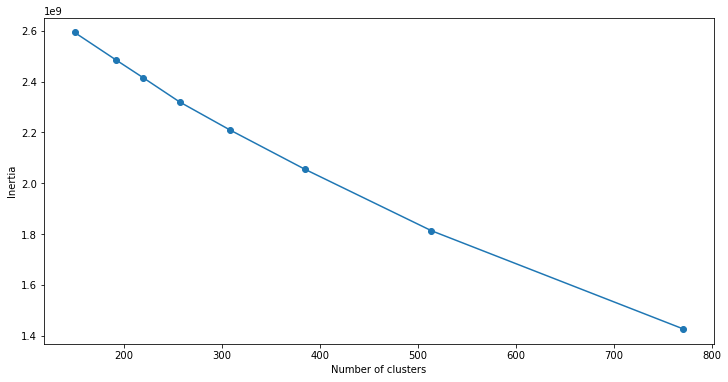

In [17]:
%%time

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':[150,192,220,257,308,385,514,771], 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.savefig("VGG16.png")

In [ ]:
%%time
frame

<Figure size 432x288 with 0 Axes>